## **Modelo de Probabilidad Sísmica Basado en Aprendizaje Automático**


---

##### *Proyecto Final del Curso Aprendizaje Estadísitico*

##**Integrantes:**

---



Andrés Felipe Chaverra Caicedo

Caterine Bedoya Bedoya



##**Sismología en Colombia**

---


Colombia, ubicada en una de las zonas tectónicas más activas del mundo, enfrenta una constante amenaza sísmica. Aunque predecir sismos con exactitud sigue siendo un desafío global, los avances en ciencia de datos ofrecen nuevas oportunidades. Este proyecto busca desarrollar un modelo de machine learning para analizar los datos históricos de sismos en Colombia, tomados desde 1993 hasta la actualidad, con el objetivo de evaluar la probabilidad de ocurrencia de eventos futuros.

#Librerías:

In [61]:
!pip install geopandas contextily -q
!pip install geopandas -q

In [62]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import geopandas as gpd

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Datos:

In [63]:
df_10 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRA8XO1EdxWUBZgS36XDWA2xtSrQMHAEV7X_fi5WhUmqWi0TrrUEEIDx9A3rgR6_wt0Sl5MsGa9onX9/pub?output=csv')
df_9 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQvIhnUkTI15iJQlBDh7_XkgNqJMG7rZLNfoTWZAxPvyep0DaPx2jdO1VhYMhvQd-Z1X8gS9I3kIG5r/pub?output=csv')
df_8 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS1zqfByNTR3h-pDZrFSzRxO6xVJ1r2s8IQYgRBV0KjyPS0Cygj70qEeSiefIgbZImv_BY6XV3O3OfK/pub?output=csv')
df_7 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRJ-oavHWkYUZ3VoM74wJv5ne4RfTB3-B2MfiMW1jtFuac2s_tRl5phF_ZYdSeu3hSAIRGMdRXVSOrB/pub?output=csv')
df_6 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTKGOjNI4CqrXcjd76PfRWXaX-D-kVUPXRIbXxEMd_mvY52-zZNWCK3WFc7ZKWowpk9dCBp4qRbVEyY/pub?output=csv')
df_5 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQs8tGHI0QLL2KQuYy3_ti7YzgA3Lh5J2dDCUolxrnmNbZNN-fZeC5p2uw0B4pkuY_SwQO83bcDTHg1/pub?output=csv')
df_4 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSkG7Sjq6Dl-ZhSoCzW9omedrDtDh9v9R-HLAZfpC8Hps-sgyvehegsessIbcrO3glMY4BlZ_PbuDg_/pub?output=csv')
df_3 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTyXkhxEtZhaHGdfENbQR1h1u9Y56MwlTIGikJv_9z1Ew9oAyH_jt3mCtXIiaDJEeCjxT_Dq_mBANWx/pub?output=csv')
df_2 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTIKyu_hMx0ctKpghri8rfCnWIwrInJQGNpSRuszvRWmGMEwPTEEDaQUxQVq-HDvdjvX0mZj_WJfB5w/pub?output=csv')
df_1 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRxfZjGTdZenInPASCl04M-DjuA3FEbZeA14ymp5y8AlenujXuYrKEadGtKKm6X-bpq7t35avZRpcUN/pub?output=csv')

Eliminamos las columnas que no son de interés

In [64]:
df = pd.concat([df_10, df_9, df_8, df_7,df_6,df_5,df_4,df_3,df_3,df_1], ignore_index=True)
df['Departamento'] = df['Región'].str.split('-').str[1]
df.drop(columns=['Fecha UTC', 'Fases','RMS (seg)', 'Gap (grados)', 'Error Latitud (Km)', 'Error Longitud (Km)', 'Error Profundidad (Km)', 'Estado' ], inplace=True)
df

Fecha Local  Latitud (grados)  Longitud (grados)  \
0       2025-07-30 19:53:27             4.377            -73.283   
1       2025-07-30 17:02:24             6.273            -77.605   
2       2025-07-30 16:43:32             6.810            -73.057   
3       2025-07-30 15:56:23             6.734            -73.051   
4       2025-07-30 15:54:02             6.708            -76.865   
...                     ...               ...                ...   
351548  1993-06-01 11:07:52             6.790            -73.077   
351549  1993-06-01 10:31:24             6.754            -73.058   
351550   1993-06-01 5:34:45             6.894            -73.171   
351551   1993-06-01 5:13:18             6.839            -73.105   
351552   1993-06-01 1:53:08             6.793            -73.151   

        Profundidad (km)  Magnitud Tipo magnitud  \
0                   14.6       3.0         MLr_3   
1                    0.0       3.1         MLr_1   
2                  142.6       1.7         MLr_3   
3                  144.0       2.4         MLr_3   
4                    4.2       1.9         MLr_1   
...                  ...       ...           ...   
351548             151.7       3.1            ML   
351549             150.0       4.4            ML   
351550             150.0       2.9            ML   
351551             152.1       2.9            ML   
351552             143.8       2.6            ML   

                                       Región    Departamento  
0       Paratebueno - Cundinamarca - Colombia   Cundinamarca   
1                             Océano Pacífico             NaN  
2           Los Santos - Santander - Colombia      Santander   
3              Aratoca - Santander - Colombia      Santander   
4              Murindó - Antioquia - Colombia      Antioquia   
...                                       ...             ...  
351548      Los Santos - Santander - Colombia      Santander   
351549          Jordán - Santander - Colombia      Santander   
351550         Betulia - Santander - Colombia      Santander   
351551      Los Santos - Santander - Colombia      Santander   
351552      Los Santos - Santander - Colombia      Santander   

[351553 rows x 8 columns]

Convertimos la fecha local en índice:

In [65]:
df["Fecha Local"] = pd.to_datetime(df["Fecha Local"], errors="coerce")
df.set_index('Fecha Local', inplace=True)
df

Latitud (grados)  Longitud (grados)  Profundidad (km)  \
Fecha Local                                                                  
2025-07-30 19:53:27             4.377            -73.283              14.6   
2025-07-30 17:02:24             6.273            -77.605               0.0   
2025-07-30 16:43:32             6.810            -73.057             142.6   
2025-07-30 15:56:23             6.734            -73.051             144.0   
2025-07-30 15:54:02             6.708            -76.865               4.2   
...                               ...                ...               ...   
1993-06-01 11:07:52             6.790            -73.077             151.7   
1993-06-01 10:31:24             6.754            -73.058             150.0   
1993-06-01 05:34:45             6.894            -73.171             150.0   
1993-06-01 05:13:18             6.839            -73.105             152.1   
1993-06-01 01:53:08             6.793            -73.151             143.8   

                     Magnitud Tipo magnitud  \
Fecha Local                                   
2025-07-30 19:53:27       3.0         MLr_3   
2025-07-30 17:02:24       3.1         MLr_1   
2025-07-30 16:43:32       1.7         MLr_3   
2025-07-30 15:56:23       2.4         MLr_3   
2025-07-30 15:54:02       1.9         MLr_1   
...                       ...           ...   
1993-06-01 11:07:52       3.1            ML   
1993-06-01 10:31:24       4.4            ML   
1993-06-01 05:34:45       2.9            ML   
1993-06-01 05:13:18       2.9            ML   
1993-06-01 01:53:08       2.6            ML   

                                                    Región    Departamento  
Fecha Local                                                                 
2025-07-30 19:53:27  Paratebueno - Cundinamarca - Colombia   Cundinamarca   
2025-07-30 17:02:24                        Océano Pacífico             NaN  
2025-07-30 16:43:32      Los Santos - Santander - Colombia      Santander   
2025-07-30 15:56:23         Aratoca - Santander - Colombia      Santander   
2025-07-30 15:54:02         Murindó - Antioquia - Colombia      Antioquia   
...                                                    ...             ...  
1993-06-01 11:07:52      Los Santos - Santander - Colombia      Santander   
1993-06-01 10:31:24          Jordán - Santander - Colombia      Santander   
1993-06-01 05:34:45         Betulia - Santander - Colombia      Santander   
1993-06-01 05:13:18      Los Santos - Santander - Colombia      Santander   
1993-06-01 01:53:08      Los Santos - Santander - Colombia      Santander   

[351553 rows x 7 columns]

Magnitudes:

In [66]:
df['Tipo magnitud'].unique()

array(['MLr_3', 'MLr_1', 'MLr_4', 'MLr_2', 'MLr_vmm', 'M', 'Mw(mB)',
       'MLr', 'mb', 'MLr_5', 'MLr_PtoGtn', 'M_Pac', 'Ms(BB)', 'Mw', 'mB',
       'Mw(mBc)', 'Mwp', 'Mw(Mwp)', 'MLv', 'M_MLr', 'mBc', 'ML', 'MW'],
      dtype=object)

Información del Dataframe:

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 351553 entries, 2025-07-30 19:53:27 to 1993-06-01 01:53:08
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Latitud (grados)   351553 non-null  float64
 1   Longitud (grados)  351553 non-null  float64
 2   Profundidad (km)   351553 non-null  float64
 3   Magnitud           351553 non-null  float64
 4   Tipo magnitud      351553 non-null  object 
 5   Región             351553 non-null  object 
 6   Departamento       342661 non-null  object 
dtypes: float64(4), object(3)
memory usage: 21.5+ MB


In [68]:
df.isnull().sum()

Latitud (grados)        0
Longitud (grados)       0
Profundidad (km)        0
Magnitud                0
Tipo magnitud           0
Región                  0
Departamento         8892
dtype: int64

Limpieza de valores nulos:

In [69]:
df = df.dropna()
df

Latitud (grados)  Longitud (grados)  Profundidad (km)  \
Fecha Local                                                                  
2025-07-30 19:53:27             4.377            -73.283              14.6   
2025-07-30 16:43:32             6.810            -73.057             142.6   
2025-07-30 15:56:23             6.734            -73.051             144.0   
2025-07-30 15:54:02             6.708            -76.865               4.2   
2025-07-30 15:33:51             6.883            -73.181             154.3   
...                               ...                ...               ...   
1993-06-01 11:07:52             6.790            -73.077             151.7   
1993-06-01 10:31:24             6.754            -73.058             150.0   
1993-06-01 05:34:45             6.894            -73.171             150.0   
1993-06-01 05:13:18             6.839            -73.105             152.1   
1993-06-01 01:53:08             6.793            -73.151             143.8   

                     Magnitud Tipo magnitud  \
Fecha Local                                   
2025-07-30 19:53:27       3.0         MLr_3   
2025-07-30 16:43:32       1.7         MLr_3   
2025-07-30 15:56:23       2.4         MLr_3   
2025-07-30 15:54:02       1.9         MLr_1   
2025-07-30 15:33:51       1.8         MLr_3   
...                       ...           ...   
1993-06-01 11:07:52       3.1            ML   
1993-06-01 10:31:24       4.4            ML   
1993-06-01 05:34:45       2.9            ML   
1993-06-01 05:13:18       2.9            ML   
1993-06-01 01:53:08       2.6            ML   

                                                    Región    Departamento  
Fecha Local                                                                 
2025-07-30 19:53:27  Paratebueno - Cundinamarca - Colombia   Cundinamarca   
2025-07-30 16:43:32      Los Santos - Santander - Colombia      Santander   
2025-07-30 15:56:23         Aratoca - Santander - Colombia      Santander   
2025-07-30 15:54:02         Murindó - Antioquia - Colombia      Antioquia   
2025-07-30 15:33:51        Zapatoca - Santander - Colombia      Santander   
...                                                    ...             ...  
1993-06-01 11:07:52      Los Santos - Santander - Colombia      Santander   
1993-06-01 10:31:24          Jordán - Santander - Colombia      Santander   
1993-06-01 05:34:45         Betulia - Santander - Colombia      Santander   
1993-06-01 05:13:18      Los Santos - Santander - Colombia      Santander   
1993-06-01 01:53:08      Los Santos - Santander - Colombia      Santander   

[342661 rows x 7 columns]

Filtro para eliminar filas con datos errórenos:

In [70]:
# Filtrar por latitud
df = df[(df["Latitud (grados)"] <= 12.5) & (df["Latitud (grados)"] >= -4) ]

# Filtrar por longitud
df = df[(df["Longitud (grados)"] <= -66.85) & (df["Longitud (grados)"] >= -79.0)]

# Filtrar por profundidad
df = df[df['Profundidad (km)'] > 0]
df

Latitud (grados)  Longitud (grados)  Profundidad (km)  \
Fecha Local                                                                  
2025-07-30 19:53:27             4.377            -73.283              14.6   
2025-07-30 16:43:32             6.810            -73.057             142.6   
2025-07-30 15:56:23             6.734            -73.051             144.0   
2025-07-30 15:54:02             6.708            -76.865               4.2   
2025-07-30 15:33:51             6.883            -73.181             154.3   
...                               ...                ...               ...   
1993-06-01 11:07:52             6.790            -73.077             151.7   
1993-06-01 10:31:24             6.754            -73.058             150.0   
1993-06-01 05:34:45             6.894            -73.171             150.0   
1993-06-01 05:13:18             6.839            -73.105             152.1   
1993-06-01 01:53:08             6.793            -73.151             143.8   

                     Magnitud Tipo magnitud  \
Fecha Local                                   
2025-07-30 19:53:27       3.0         MLr_3   
2025-07-30 16:43:32       1.7         MLr_3   
2025-07-30 15:56:23       2.4         MLr_3   
2025-07-30 15:54:02       1.9         MLr_1   
2025-07-30 15:33:51       1.8         MLr_3   
...                       ...           ...   
1993-06-01 11:07:52       3.1            ML   
1993-06-01 10:31:24       4.4            ML   
1993-06-01 05:34:45       2.9            ML   
1993-06-01 05:13:18       2.9            ML   
1993-06-01 01:53:08       2.6            ML   

                                                    Región    Departamento  
Fecha Local                                                                 
2025-07-30 19:53:27  Paratebueno - Cundinamarca - Colombia   Cundinamarca   
2025-07-30 16:43:32      Los Santos - Santander - Colombia      Santander   
2025-07-30 15:56:23         Aratoca - Santander - Colombia      Santander   
2025-07-30 15:54:02         Murindó - Antioquia - Colombia      Antioquia   
2025-07-30 15:33:51        Zapatoca - Santander - Colombia      Santander   
...                                                    ...             ...  
1993-06-01 11:07:52      Los Santos - Santander - Colombia      Santander   
1993-06-01 10:31:24          Jordán - Santander - Colombia      Santander   
1993-06-01 05:34:45         Betulia - Santander - Colombia      Santander   
1993-06-01 05:13:18      Los Santos - Santander - Colombia      Santander   
1993-06-01 01:53:08      Los Santos - Santander - Colombia      Santander   

[322514 rows x 7 columns]

Magnitud máxima:

In [71]:
df[df['Magnitud'] == df['Magnitud'].max()]

Latitud (grados)  Longitud (grados)  Profundidad (km)  \
Fecha Local                                                                  
2019-02-22 05:17:22            -2.199            -77.023             132.4   

                     Magnitud Tipo magnitud            Región Departamento  
Fecha Local                                                                 
2019-02-22 05:17:22       7.5       Mw(Mwp)  Palora - Ecuador      Ecuador

##Shaperile:
 Un shapefile es un formato sencillo y no topológico que se utiliza para almacenar la ubicación geométrica y la información de atributos de las entidades geográficas. Las entidades geográficas de un shapefile se pueden representar por medio de puntos, líneas o polígonos (áreas). El espacio de trabajo que contiene shapefiles también puede contener tablas dBASE que, a su vez, pueden almacenar atributos adicionales que se pueden unir a las entidades de un shapefile.

 https://desktop.arcgis.com/es/arcmap/latest/manage-data/shapefiles/what-is-a-shapefile.htm



In [72]:
# 1) Descargar shapefile de departamentos (nivel administrativo 1)
!wget -O ne_10m_admin_1_states_provinces.zip \
    https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
!unzip -o ne_10m_admin_1_states_provinces.zip -d admin1_shp

# 2) Leer shapefile
admin1 = gpd.read_file("admin1_shp/ne_10m_admin_1_states_provinces.shp")

# 3) Filtrar solo Colombia
departamentos = admin1[admin1["admin"] == "Colombia"].to_crs("EPSG:4326")

# 4) Renombrar columnas en tu dataframe
if "Latitud (grados)" in df.columns and "Longitud (grados)" in df.columns:
    df1 = df.rename(columns={
        "Latitud (grados)": "Latitud",
        "Longitud (grados)": "Longitud"
    })
else:
    df1 = df.copy()

# 5) Crear GeoDataFrame de puntos
gdf = gpd.GeoDataFrame(
    df1,
    geometry=gpd.points_from_xy(df1["Longitud"], df1["Latitud"]),
    crs="EPSG:4326"
)

--2025-08-23 18:26:20--  https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
Resolving naciscdn.org (naciscdn.org)... 13.226.52.56, 13.226.52.2, 13.226.52.31, ...
Connecting to naciscdn.org (naciscdn.org)|13.226.52.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14909524 (14M) [application/zip]
Saving to: ‘ne_10m_admin_1_states_provinces.zip’

ne_10m_admin_1_stat 100%[===================>]  14.22M  46.1MB/s    in 0.3s    

2025-08-23 18:26:21 (46.1 MB/s) - ‘ne_10m_admin_1_states_provinces.zip’ saved [14909524/14909524]

Archive:  ne_10m_admin_1_states_provinces.zip
  inflating: admin1_shp/ne_10m_admin_1_states_provinces.README.html  
 extracting: admin1_shp/ne_10m_admin_1_states_provinces.VERSION.txt  
 extracting: admin1_shp/ne_10m_admin_1_states_provinces.cpg  
  inflating: admin1_shp/ne_10m_admin_1_states_provinces.dbf  
  inflating: admin1_shp/ne_10m_admin_1_states_provinces.prj  
  inflating: admin1_shp/ne_10m_admin_1_sta

------------------------------------------------------------------------------------------------------------

#**Longitud vs Latitud**

#Categorías para la magnitud de los sismos:
- Micro: $< 2.0$
- Menor: $2.0 - 3.9$
- Ligero: $4.0 - 4.9$
- Moderado: $5.0 - 5.9$
- Fuerte: $6.0 - 6.9$
- Mayor: $7.0 - 7.9$
- Gran $8.0 - 8.9$

https://es.wikipedia.org/wiki/Escala_sismol%C3%B3gica_de_Richter

El gráfico a continuación muestra mapas de distribución espacial de sismos en Colombia, clasificados por categorías de magnitud. Cada subgráfico corresponde a un rango de magnitud específico y se representa con círculos cuyo color y tamaño indican la magnitud del evento:

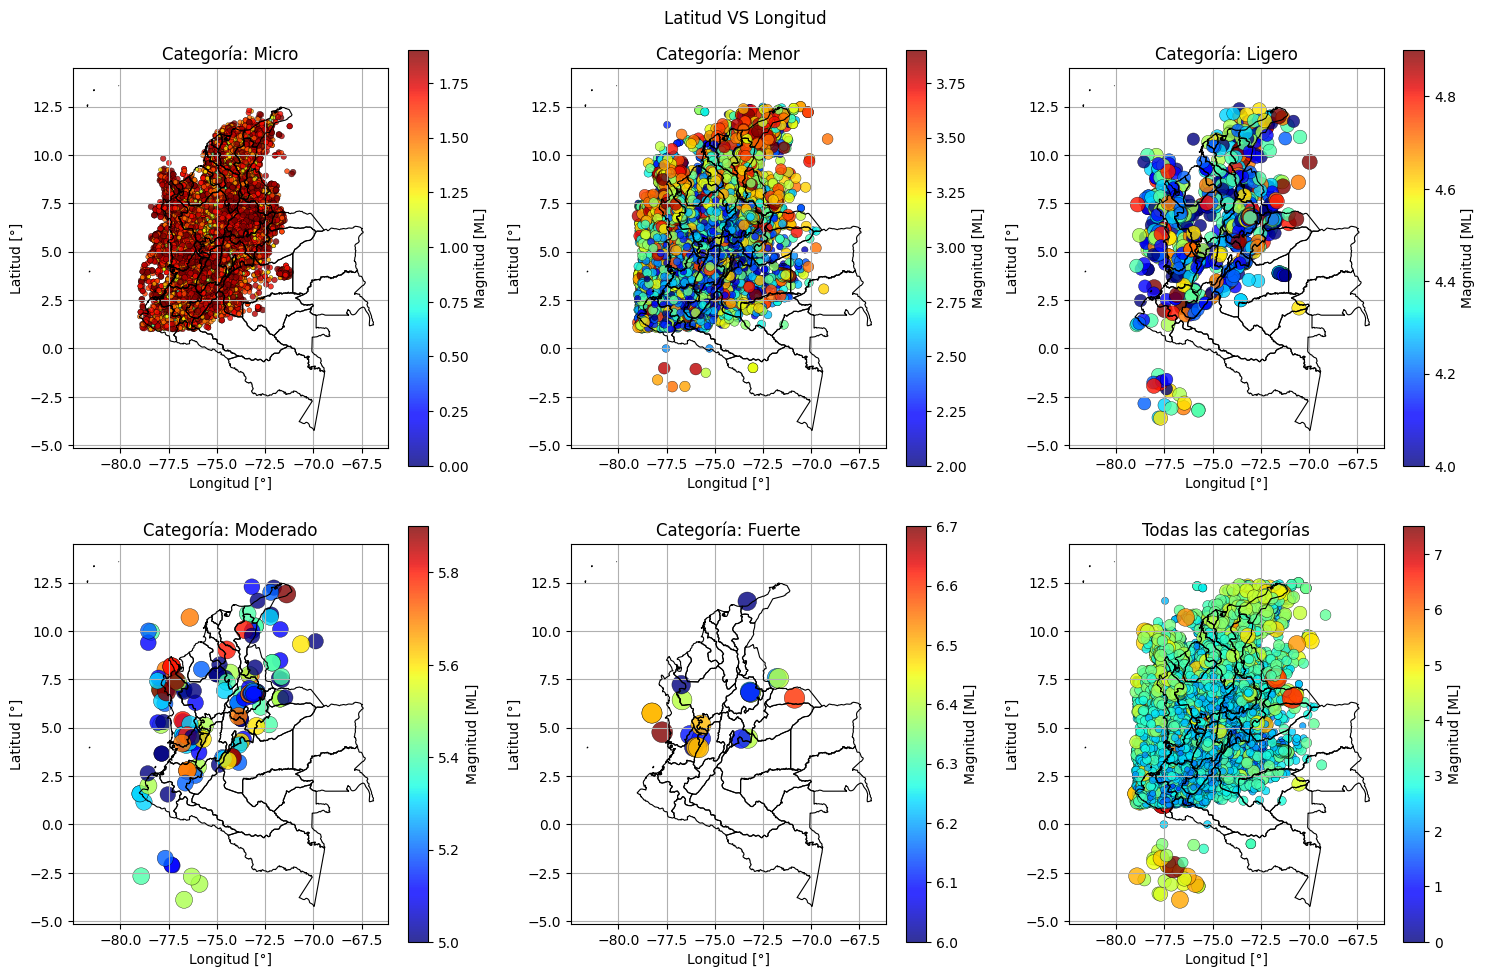

In [73]:
bins = [-float('inf'), 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, float('inf')]
labels = ['Micro', 'Menor', 'Ligero', 'Moderado', 'Fuerte', 'Mayor', 'Gran']
df['Categoria'] = pd.cut(df['Magnitud'], bins=bins, labels=labels, right=False)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Latitud VS Longitud')
axs = axs.flatten()

# Caregorías de 1 hasta 5
for i in range(5):
    departamentos.boundary.plot(ax=axs[i], color="black", linewidth=0.8)
    df_mod = df[df["Categoria"] == labels[i]]
    # scatter = axs[i].scatter(df_mod["Longitud (grados)"], df_mod["Latitud (grados)"],
    #                   c=df_mod["Magnitud"], cmap='jet', s=20, alpha=1.0)

    scatter = axs[i].scatter(df_mod["Longitud (grados)"], df_mod["Latitud (grados)"], s=df_mod["Magnitud"].clip(upper=7)**2 * 5,
                      c=df_mod["Magnitud"], cmap='jet', alpha=0.8,edgecolors="black",linewidth=0.3)
    plt.colorbar(scatter, label='Magnitud [ML]')
    axs[i].set_title('Categoría: %s'%labels[i])
    axs[i].set_ylabel('Latitud [°]')
    axs[i].set_xlabel('Longitud [°]')
    axs[i].grid()

# Todas las categorías:
departamentos.boundary.plot(ax=axs[5], color="black", linewidth=0.8)
# scatter = axs[5].scatter(df["Longitud (grados)"], df["Latitud (grados)"],
#                       c=df["Magnitud"], cmap='jet', s=20, alpha=1.0)
scatter = axs[5].scatter(df["Longitud (grados)"], df["Latitud (grados)"], s=df["Magnitud"].clip(upper=7)**2 * 5,
                      c=df["Magnitud"], cmap='jet', alpha=0.8, edgecolors="black",linewidth=0.3)

plt.colorbar(scatter, label='Magnitud [ML]')
axs[5].set_title('Todas las categorías')
axs[5].set_ylabel('Latitud [°]')
axs[5].set_xlabel('Longitud [°]')
axs[5].grid()

plt.tight_layout()
plt.show()

#Análisis por subgráfico:

**Categoría Micro $( < 2.0 ML)$**

- Se observa una gran densidad de eventos en el occidente del país, sobre todo en la región andina (Cordillera Occidental y Central).

- La mayoría son sismos muy frecuentes y poco perceptibles para la población.

**Categoría Menor $(2.0ML – 3.9 ML)$**

- Los eventos están más dispersos en todo el país, especialmente en la región andina y hacia el suroccidente.

- Siguen siendo sismos frecuentes, algunos perceptibles por la población.

**Categoría Ligero $(4.0ML – 4.9 ML)$**

- Aparecen menos eventos en comparación con las categorías anteriores.

- Localizados principalmente en las cordilleras, especialmente en zonas de fallas activas.

- Estos sismos ya son claramente perceptibles en las áreas cercanas al epicentro.

**Categoría Moderado $(5.0ML – 5.9 ML)$**

- Los sismos de esta magnitud son menos frecuentes.

- Se distribuyen principalmente en la región central y occidental.

- Son capaces de generar daños leves a moderados en estructuras vulnerables.

**Categoría Fuerte $(6.0ML – 6.9 ML)$**

- Muy pocos eventos en el registro, pero se concentran en zonas sísmicamente activas (Eje Cafetero, Santander, occidente del país).

- Estos sismos tienen un alto potencial destructivo.

Todas las categorías

- Se visualiza claramente que la zona andina de Colombia es la más activa sísmicamente.

- Existe concentración en áreas como:

 - Nido sísmico de Bucaramanga (Santander): una de las zonas más activas del mundo en sismos intermedios.

 - Eje Cafetero y Valle del Cauca: asociados a la subducción de la placa de Nazca bajo Suramérica.

 - Occidente (Cauca y Nariño): también con fuerte actividad tectónica.

**Conclusiones principales:**

- La gran mayoría de los sismos en Colombia son de baja magnitud (micro y menores).

- Los sismos destructivos $(≥6.0 ML)$ son poco frecuentes, pero ocurren en zonas bien delimitadas.

- La distribución espacial muestra la influencia de las fallas tectónicas andinas y la subducción de la placa de Nazca.

- Se evidencia que el país está en una región sísmicamente activa, especialmente en la cordillera de los Andes y el suroccidente.

In [74]:
df

Latitud (grados)  Longitud (grados)  Profundidad (km)  \
Fecha Local                                                                  
2025-07-30 19:53:27             4.377            -73.283              14.6   
2025-07-30 16:43:32             6.810            -73.057             142.6   
2025-07-30 15:56:23             6.734            -73.051             144.0   
2025-07-30 15:54:02             6.708            -76.865               4.2   
2025-07-30 15:33:51             6.883            -73.181             154.3   
...                               ...                ...               ...   
1993-06-01 11:07:52             6.790            -73.077             151.7   
1993-06-01 10:31:24             6.754            -73.058             150.0   
1993-06-01 05:34:45             6.894            -73.171             150.0   
1993-06-01 05:13:18             6.839            -73.105             152.1   
1993-06-01 01:53:08             6.793            -73.151             143.8   

                     Magnitud Tipo magnitud  \
Fecha Local                                   
2025-07-30 19:53:27       3.0         MLr_3   
2025-07-30 16:43:32       1.7         MLr_3   
2025-07-30 15:56:23       2.4         MLr_3   
2025-07-30 15:54:02       1.9         MLr_1   
2025-07-30 15:33:51       1.8         MLr_3   
...                       ...           ...   
1993-06-01 11:07:52       3.1            ML   
1993-06-01 10:31:24       4.4            ML   
1993-06-01 05:34:45       2.9            ML   
1993-06-01 05:13:18       2.9            ML   
1993-06-01 01:53:08       2.6            ML   

                                                    Región    Departamento  \
Fecha Local                                                                  
2025-07-30 19:53:27  Paratebueno - Cundinamarca - Colombia   Cundinamarca    
2025-07-30 16:43:32      Los Santos - Santander - Colombia      Santander    
2025-07-30 15:56:23         Aratoca - Santander - Colombia      Santander    
2025-07-30 15:54:02         Murindó - Antioquia - Colombia      Antioquia    
2025-07-30 15:33:51        Zapatoca - Santander - Colombia      Santander    
...                                                    ...             ...   
1993-06-01 11:07:52      Los Santos - Santander - Colombia      Santander    
1993-06-01 10:31:24          Jordán - Santander - Colombia      Santander    
1993-06-01 05:34:45         Betulia - Santander - Colombia      Santander    
1993-06-01 05:13:18      Los Santos - Santander - Colombia      Santander    
1993-06-01 01:53:08      Los Santos - Santander - Colombia      Santander    

                    Categoria  
Fecha Local                    
2025-07-30 19:53:27     Menor  
2025-07-30 16:43:32     Micro  
2025-07-30 15:56:23     Menor  
2025-07-30 15:54:02     Micro  
2025-07-30 15:33:51     Micro  
...                       ...  
1993-06-01 11:07:52     Menor  
1993-06-01 10:31:24    Ligero  
1993-06-01 05:34:45     Menor  
1993-06-01 05:13:18     Menor  
1993-06-01 01:53:08     Menor  

[322514 rows x 8 columns]

Agrupación de sismos por categorías, para ampliar el análisis con respecto a las frecencias:

In [75]:
df.groupby("Categoria").count()['Magnitud']

/tmp/ipython-input-3155649979.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("Categoria").count()['Magnitud']


Categoria
Micro       203095
Menor       116777
Ligero        2372
Moderado       244
Fuerte          21
Mayor            5
Gran             0
Name: Magnitud, dtype: int64

#Mapa de calor de magnitudes:

In [76]:
Micro = df[df["Categoria"] == 'Micro']
Menor = df[df["Categoria"] == 'Menor']
Ligero = df[df["Categoria"] == 'Ligero']
Moderado = df[df["Categoria"] == 'Moderado']
Fuerte = df[df["Categoria"] == 'Fuerte']

In [77]:
def Map(DF, labels):
  longitud = np.linspace(DF["Longitud (grados)"].min(), DF["Longitud (grados)"].max(), 200)
  latitud = np.linspace(DF["Latitud (grados)"].min(), DF["Latitud (grados)"].max(), 200)

  X, Y = np.meshgrid(longitud, latitud)
  Z = griddata((DF["Longitud (grados)"], DF["Latitud (grados)"]), DF["Magnitud"], (X, Y), method='cubic')
  Z = Z.reshape(X.shape)

  # Contunuo:
  Z_suavizado = gaussian_filter(Z, sigma=1.5)

  # Prevenir que Z se salga del rango mediante interpolación:
  Z_clipped = np.clip(Z_suavizado, DF['Magnitud'].min(), DF['Magnitud'].max())


  fig = plt.figure(figsize=(12, 6))
  fig.suptitle('Mapa de Calor de Magnitud: Categoría %s'%labels)


  # --- Subplot 1: Contorno 2D ---
  ax1 = fig.add_subplot(121)
  departamentos.boundary.plot(ax=ax1, color="black", linewidth=0.8)
  contour = ax1.contourf(X, Y, Z_clipped, cmap='jet', alpha=0.9)
  plt.colorbar(contour, ax=ax1, label='Magnitud [ML]', orientation='horizontal')

  # Puntos
  ax1.scatter(
      DF["Longitud (grados)"],
      DF["Latitud (grados)"],
      c='w', s=20, edgecolor='black', alpha=0.00
  )
  ax1.set_xlabel('Longitud [°]')
  ax1.set_ylabel('Latitud [°]')
  ax1.set_title('Mapa de Contornos 2D')
  ax1.grid()
  ax1.set_ylim(DF["Latitud (grados)"].min(), DF["Latitud (grados)"].max())
  ax1.set_xlim(DF["Longitud (grados)"].min(), DF["Longitud (grados)"].max())

  # Líneas de contorno
  levels = np.linspace(DF['Magnitud'].min(), DF['Magnitud'].max(), 10)  # 10 niveles entre min y max
  contour_lines = ax1.contour(X, Y, Z_clipped, levels=levels, colors='white', linewidths=0.5)
  # Etiquetas blancas para las líneas de contorno
  ax1.clabel(contour_lines, inline=True, fontsize=8, colors='w', fmt='%1.1f')


  # --- Subplot 2: Superficie 3D ---
  ax2 = fig.add_subplot(122, projection='3d')
  surf = ax2.plot_surface(
      X, Y, Z_clipped,
      cmap='jet',
      edgecolor='none',
      alpha=0.8,
      rstride=1,
      cstride=1  # Control de densidad de la malla 3D
  )
  plt.colorbar(surf, ax=ax2, label='Magnitud [°]', shrink=0.5, aspect=10)
  ax2.set_xlabel('Longitud [°]')
  ax2.set_ylabel('Latitud [°]')
  ax2.set_zlabel('Magnitud [ML]')
  ax2.set_title('Superficie 3D')
  #ax2.view_init(elev=30, azim=45)  # Ángulo de vista

  plt.tight_layout()
  plt.show()

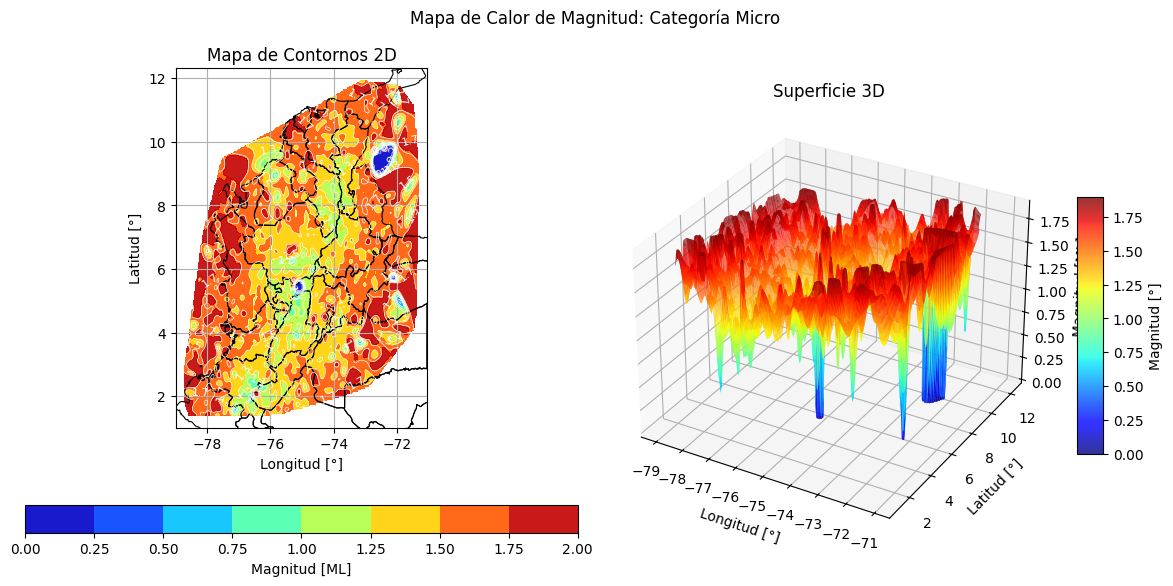

In [78]:
Map(Micro, 'Micro')

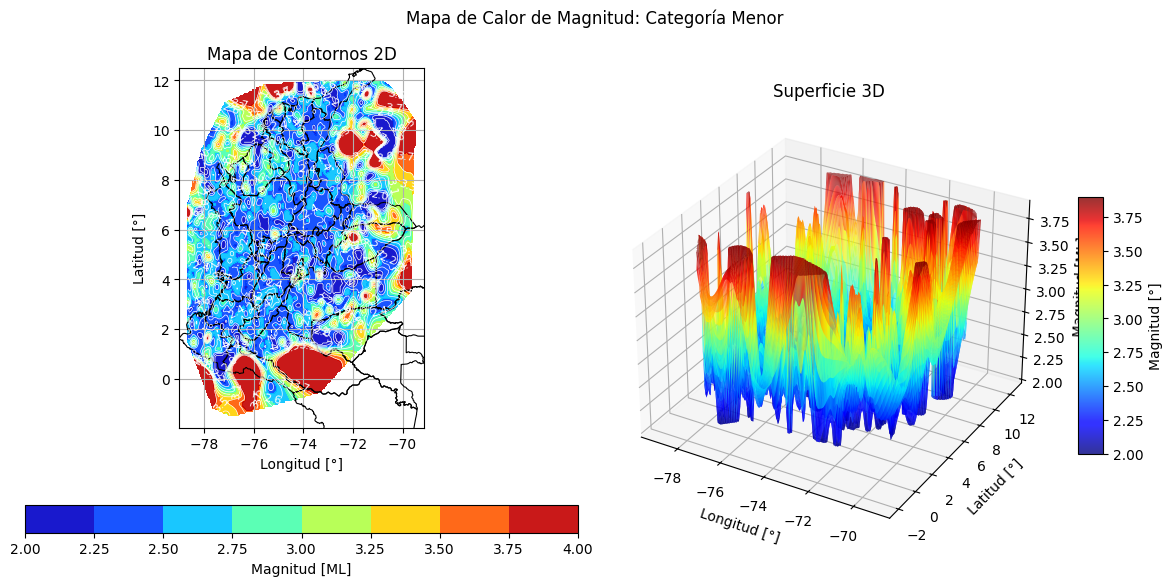

In [79]:
Map(Menor, 'Menor')

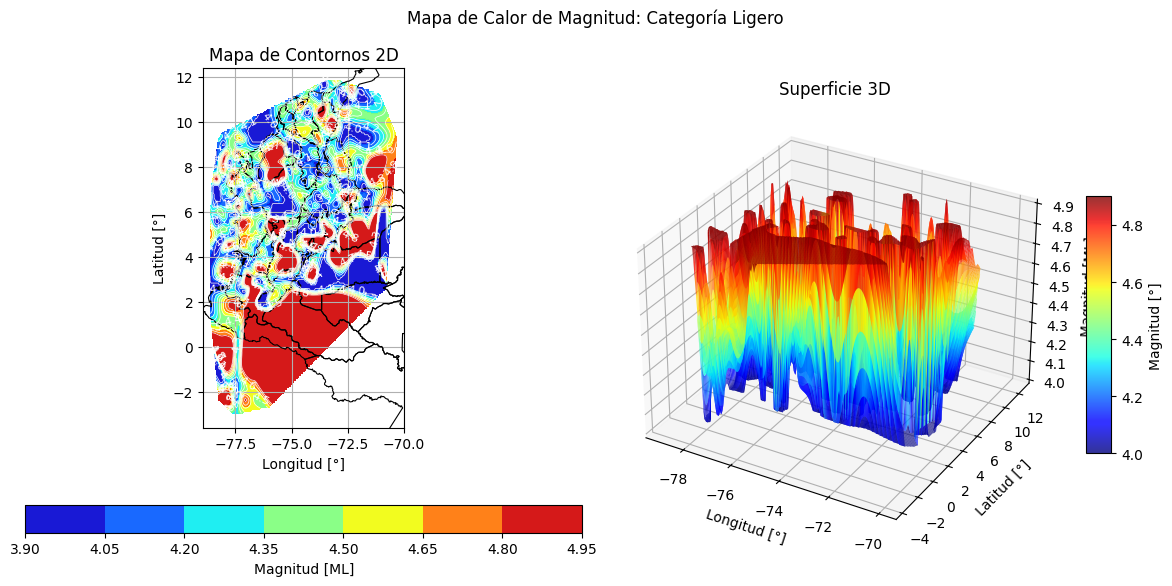

In [80]:
Map(Ligero, 'Ligero')

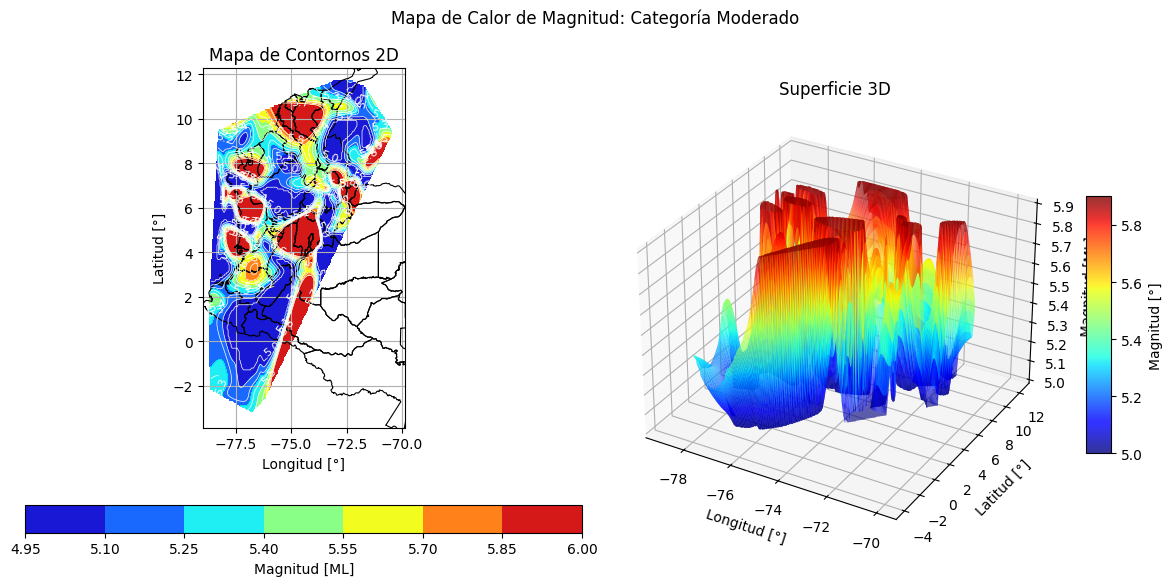

In [81]:
Map(Moderado, 'Moderado')

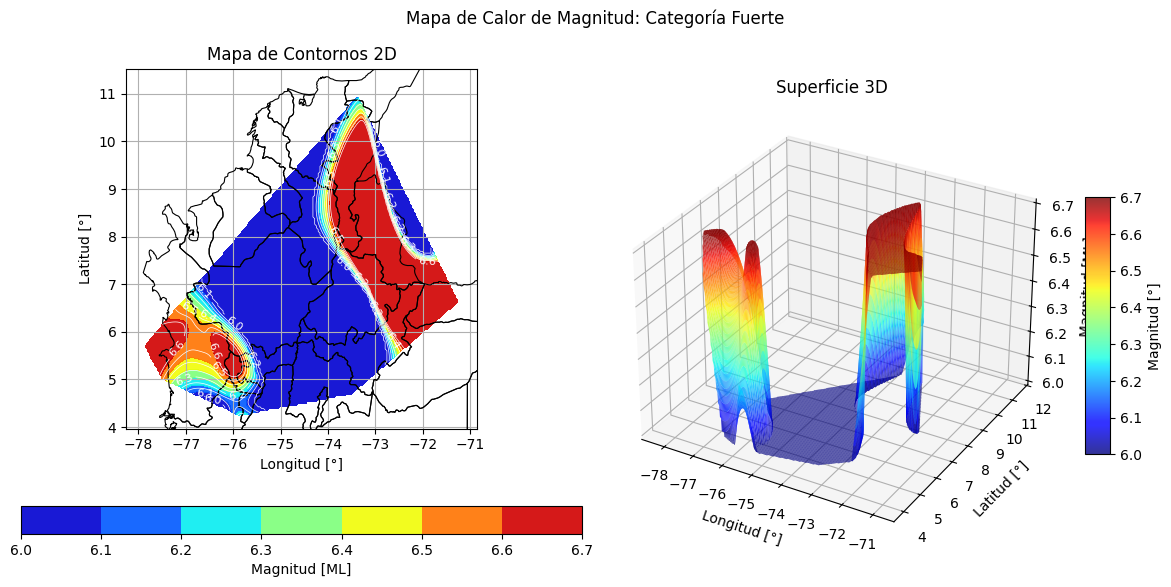

In [82]:
Map(Fuerte, 'Fuerte')

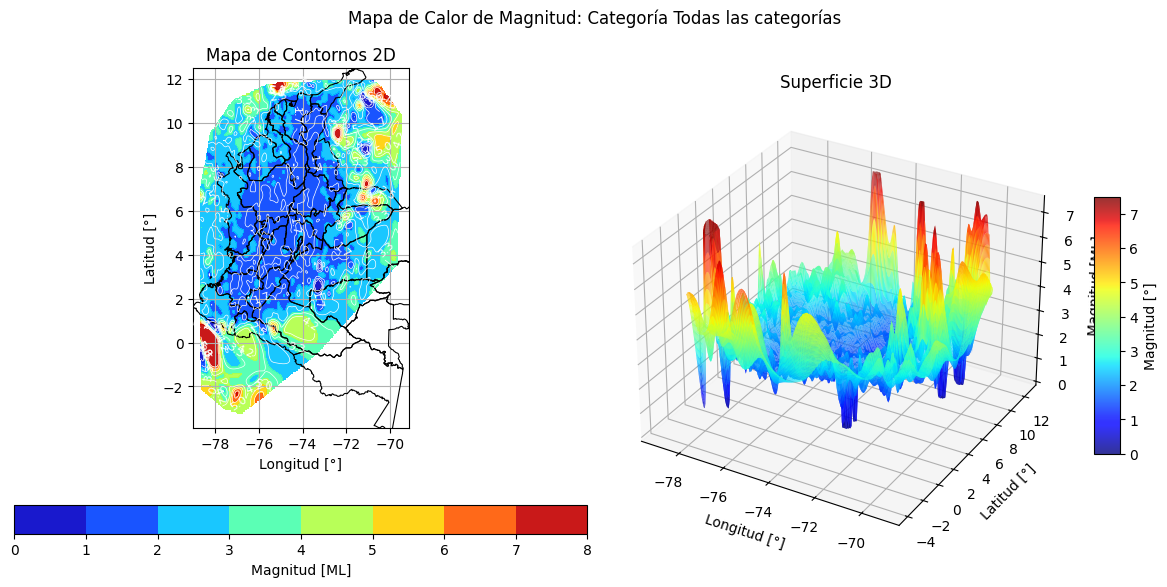

In [83]:
Map(df, 'Todas las categorías')

----------------------------------------------------------------------------------------------------------------------------------------------------------------


#Conclusiones

- La mayoría de los sismos en Colombia tienen baja magnitud, pero existen focos con potencial de sismos fuertes.

- Tres regiones críticas:

 - Nido sísmico de Bucaramanga (Santander).

 - Suroccidente colombiano (Cauca – Nariño).

 - Eje Cafetero – Antioquia.

- El contraste entre el mapa 2D y la superficie 3D ayuda a visualizar no solo la ubicación espacial, sino también la "intensidad relativa" de los eventos.

-----------------------------------------------------------------------------------------------------------------------

#**¿Cómo se correlacionan las variables?**

#Profundidad vs. Magnitud
¿Los sismos más profundos tienden a tener mayor o menor magnitud?

##Profundidad vs. Ubicación geográfica
¿Hay regiones donde los sismos son más superficiales o profundos?

## Matriz de correlación:

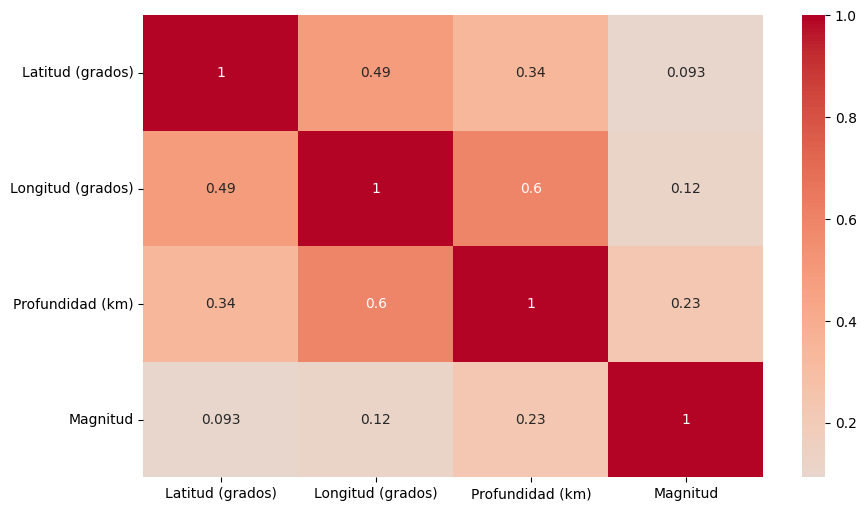

In [84]:
""" Practicar la diferencia en cmap default con cmap coolwarm: """
# cmap=coolwarm -> permite visualizar mejor los extremos positivos y negativos.
#
numerical_df = df.select_dtypes(include=['float', 'int'])     # Seleccionamos sólo las variables cuantitativas

corr_matrix = numerical_df.corr()
corr_matrix

plt.figure(figsize = (10,6))
# annot=True -> Permite ver los valores de correlación dentro de cada celda
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

- La ubicación geográfica (latitud y longitud) de los sismos está más correlacionada con la profundidad, lo cual refleja la influencia de la tectónica de placas en Colombia.

- La magnitud es prácticamente independiente de la latitud y longitud, y solo muestra una leve tendencia con la profundidad.

- En términos simples: dónde ocurre el sismo depende de la tectónica (lat/long/profundidad), pero qué tan fuerte es (magnitud) no está condicionado fuertemente por esas variables.

------------------------------------------------------------------------------------------------------------------------------------

#**Histogramas**
A continuación vamos a ver cómo se distribuyen los sismos en función de los departamentos, y profundidad para así sacar conclusiones:

In [85]:
## Clean and standardize department names
df['Departamento'] = df['Región'].str.split('-').str[1].str.strip().str.title()

df['Departamento'] = df['Departamento'].replace(" VALLE DEL CAUCA ", " Valle del Cauca ")
df['Departamento'] = df['Departamento'].replace(" la Guajira ", " La Guajira ") # This replacement might not be strictly necessary after .str.title() but is good practice
# Display unique values to verify
print(df["Departamento"].unique())

['Cundinamarca' 'Santander' 'Antioquia' 'Córdoba' 'Huila'
 'Norte De Santander' 'Valle Del Cauca' 'Boyacá' 'Meta' 'Chocó' 'Cesar'
 'Magdalena' 'Tolima' 'Caquetá' 'Quindío' 'Caldas' 'Colombia' 'Bolívar'
 'Venezuela' 'Ecuador.' 'Casanare' 'La Guajira' 'Cauca' 'Nariño' 'Ecuador'
 'Sucre' 'Risaralda' 'Atlántico' 'Arauca' 'Peru' 'Vichada' 'Guaviare'
 'Condorcanqui' 'Putumayo' 'Pastaza' 'Panama' 'Vaupés' 'Alto Amazonas'
 'Guainía' 'Canar' 'Ecuador Border Region' 'Esmeraldas'
 'San Andrés Providencia' 'Colombia Border Region' 'Zulia' 'Panamá'
 'Emberá' 'Táchira' 'Darién' 'Dependencia Federal' 'Carchi'
 'Industrial Y Portuario)' 'Guna Yala' 'Falcón' 'El Chivo' 'Colón' 'Apure'
 'Sucumbíos' 'Imbabura' 'Amazonas' 'Barinas' 'Napo']


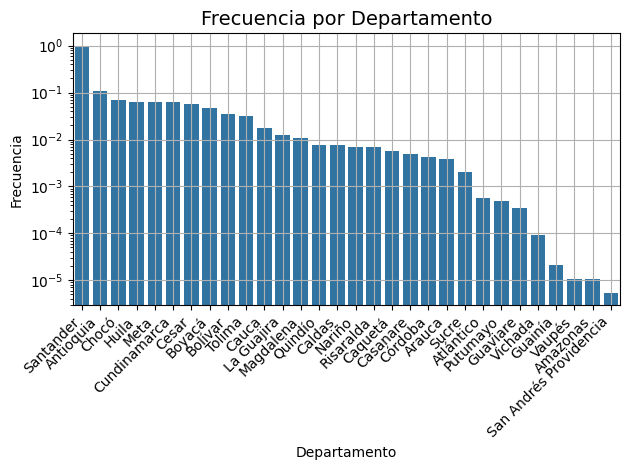

In [86]:
departamentos_colombia = [
    "Amazonas", "Antioquia", "Arauca", "Atlántico", "Bolívar", "Boyacá", "Caldas",
    "Caquetá", "Casanare", "Cauca", "Cesar", "Chocó", "Córdoba", "Cundinamarca",
    "Guainía", "Guaviare", "Huila", "La Guajira", "Magdalena", "Meta",
    "Nariño", "Norte de Santander", "Putumayo", "Quindío", "Risaralda", "San Andrés Providencia",
    "Santander", "Sucre", "Tolima", "Valle del Cauca", "Vaupés", "Vichada"
]

# Filtrar solo departamentos oficiales
df_filtrado = df[df['Departamento'].isin(departamentos_colombia)]

# Contar registros por departamento
conteo_departamentos = df_filtrado['Departamento'].value_counts()

plt.figure()
sns.barplot(x=conteo_departamentos.index, y=conteo_departamentos.values/conteo_departamentos.values.max())
plt.ylabel("Frecuencia")
plt.xlabel("Departamento")
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas
plt.title("Frecuencia por Departamento", fontsize=14)

# Escala logarítmica opcional para mejorar visibilidad
plt.yscale('log')

plt.tight_layout()
plt.grid(True)
plt.show()


La ocurrencia de eventos no es homogénea entre departamentos, sino que está fuertemente concentrada en unos pocos, lo cual puede reflejar factores como densidad poblacional, actividad económica, geografía o características específicas de cada región.

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-958510781.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'$\mu$ = {media:.2f} ML')


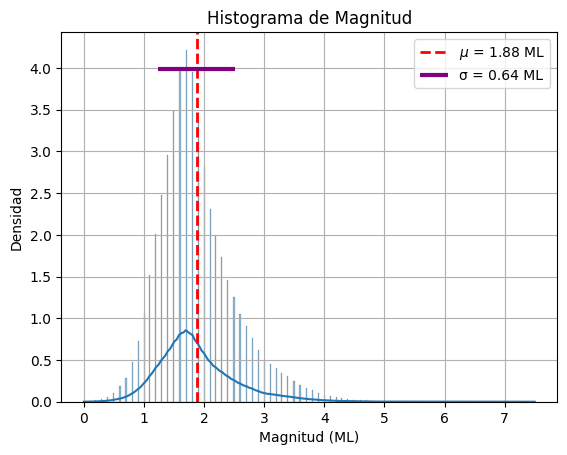

In [87]:
plt.figure()
plt.title('Histograma de Magnitud')

# Histograma con densidad y curva KDE
sns.histplot(data=df, x="Magnitud", stat="density", kde=True)

# Calcular media y desviación estándar
media = df["Magnitud"].mean()
desv = df["Magnitud"].std()

# Agregar línea vertical en la media
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'$\mu$ = {media:.2f} ML')

# Obtener altura máxima del histograma para posicionar la línea
altura = plt.gca().get_ylim()[1] * 0.9  # al 90% del alto

# Agregar línea horizontal que mida la desviación estándar
plt.hlines(y=altura, xmin=media - desv, xmax=media + desv,
           colors='purple', linestyles='-', linewidth=3,
           label=f'σ = {desv:.2f} ML')

# Etiquetas y formato
plt.xlabel("Magnitud (ML)")
plt.ylabel("Densidad")
plt.grid()
plt.legend()
plt.show()



- La sismicidad registrada está dominada por sismos pequeños (magnitud < 3).

- Los sismos fuertes son mucho menos frecuentes, pero su presencia alarga la distribución hacia magnitudes altas.

- En términos estadísticos, la distribución de magnitudes es asimétrica positiva, concentrada en torno a valores bajos.

<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-694368105.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'$\mu$ = {media:.2f} km')


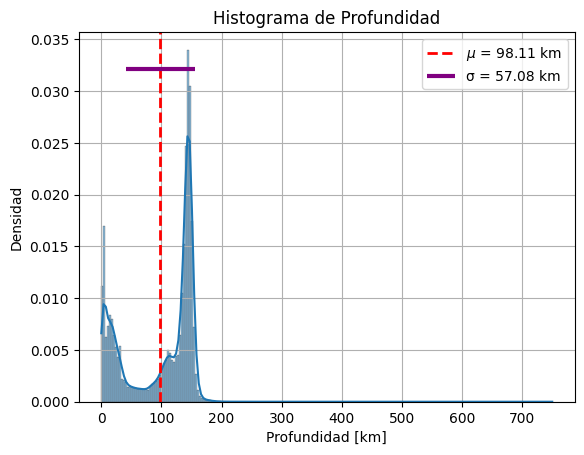

In [88]:
plt.figure()
sns.histplot(data=df, x="Profundidad (km)", stat="density", kde=True)
plt.title('Histograma de Profundidad')

# Calcular media y desviación estándar
media = df["Profundidad (km)"].mean()
desv = df["Profundidad (km)"].std()

# Línea vertical en la media
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'$\mu$ = {media:.2f} km')

# Altura para ubicar la línea horizontal
altura = plt.gca().get_ylim()[1] * 0.9  # 90% del alto del eje Y

# Línea horizontal que representa ±1σ
plt.hlines(y=altura, xmin=media - desv, xmax=media + desv,
           colors='purple', linestyles='-', linewidth=3,
           label=f'σ = {desv:.2f} km')

# Etiquetas y formato
plt.xlabel("Profundidad [km]")
plt.ylabel("Densidad")
plt.grid()
plt.legend()
plt.show()


- La profundidad de los sismos no se distribuye de manera uniforme ni normal, sino en múltiples picos (multimodal).

- Los sismos más frecuentes ocurren cerca de la superficie y a profundidades intermedias, mientras que los muy profundos son excepcionales.

- La media por sí sola no describe bien la distribución, ya que los diferentes picos hacen que sea más representativo hablar de modas o intervalos de mayor densidad.

## Histograma Temporal

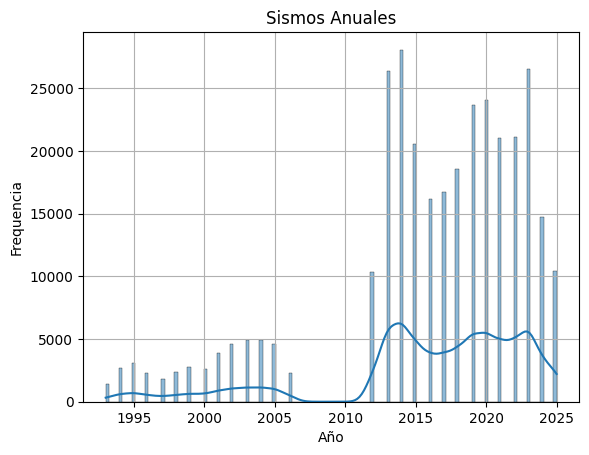

In [89]:
df.index = pd.to_datetime(df.index)
df["Año"] = df.index.year
df["Mes"] = df.index.month
df["Hora"] = df.index.hour

plt.figure()
sns.histplot(data=df, x="Año", kde=True)
plt.title("Sismos Anuales")
plt.xlabel("Año")
plt.ylabel('Frequencia')
plt.grid()
plt.show()

- La tendencia a largo plazo muestra un aumento muy significativo en el número de sismos detectados después de 2010.

- Esto refleja una mayor capacidad de detección y registro de eventos pequeños, más que un cambio drástico en la tectónica.

- La sismicidad anual está marcada por fluctuaciones cíclicas, pero el nivel de detección actual es varias veces mayor que en los 90s.

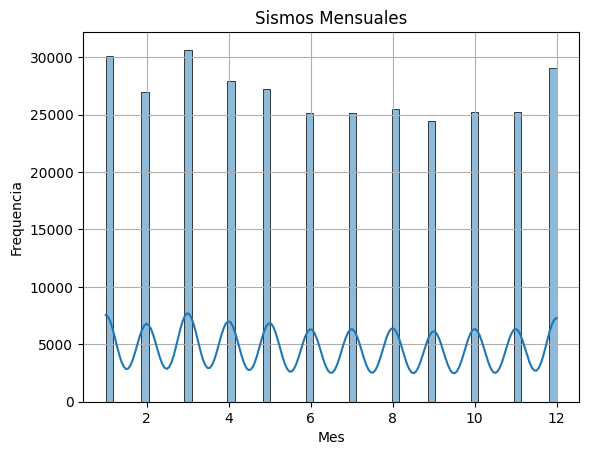

In [90]:
plt.figure()
sns.histplot(data=df, x="Mes", kde=True)
plt.title("Sismos Mensuales")
plt.xlabel("Mes")
plt.ylabel('Frequencia')
plt.grid()
plt.show()

- La actividad sísmica mensual es bastante estable, sin una marcada estacionalidad.

- Las pequeñas variaciones mensuales pueden deberse a factores instrumentales o administrativos más que a cambios tectónicos reales.

- En términos generales, no existe una dependencia significativa de la actividad sísmica con el mes del año.

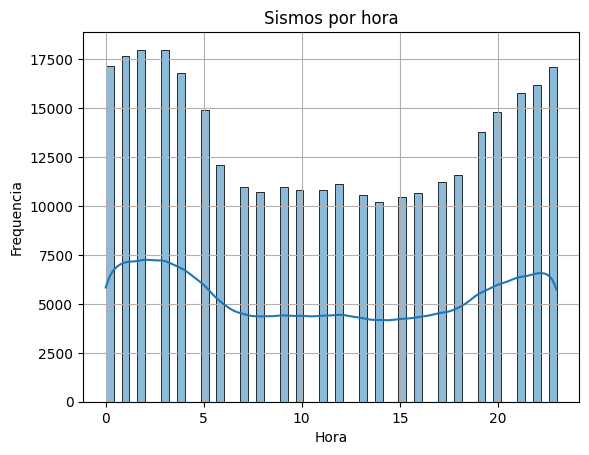

In [91]:
plt.figure()
sns.histplot(data=df, x="Hora", kde=True)
plt.title("Sismos por hora")
plt.xlabel("Hora")
plt.ylabel('Frequencia')
plt.grid()
plt.show()


- La ocurrencia de sismos no es uniforme a lo largo del día.

- Se presentan picos de mayor frecuencia en la madrugada y la noche.

- El mínimo ocurre hacia el mediodía, con menor cantidad de eventos.

- El patrón diario es bimodal, posiblemente influido por ciclos naturales (mareas) o condiciones de detección.

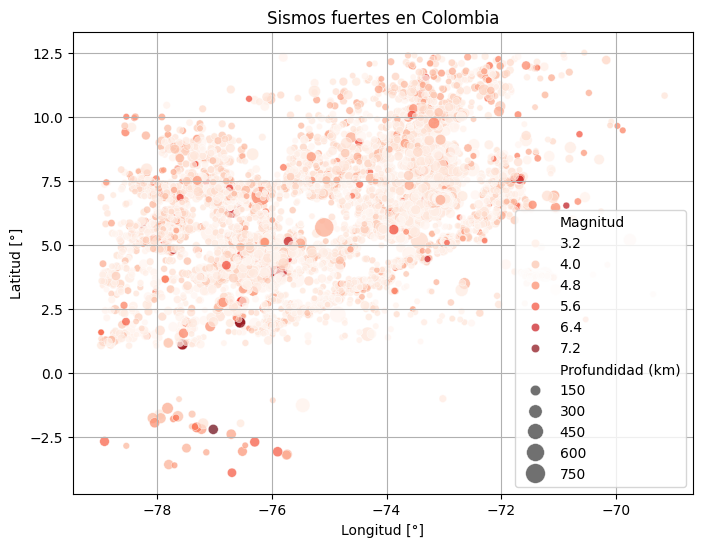

In [92]:
df_fuertes = df[df["Magnitud"] >= 3]
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_fuertes,
    x="Longitud (grados)",
    y="Latitud (grados)",
    hue="Magnitud",
    size="Profundidad (km)",
    palette="Reds",
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Sismos fuertes en Colombia")
plt.xlabel("Longitud [°]")
plt.ylabel("Latitud [°]")
plt.grid()
plt.show()

In [93]:
# 1) Descargar shapefile de departamentos (nivel administrativo 1)
!wget -O ne_10m_admin_1_states_provinces.zip \
    https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
!unzip -o ne_10m_admin_1_states_provinces.zip -d admin1_shp

# 2) Leer shapefile
admin1 = gpd.read_file("admin1_shp/ne_10m_admin_1_states_provinces.shp")

# 3) Filtrar solo Colombia
departamentos = admin1[admin1["admin"] == "Colombia"].to_crs("EPSG:4326")

# 4) Renombrar columnas en tu dataframe
if "Latitud (grados)" in df.columns and "Longitud (grados)" in df.columns:
    df1 = df.rename(columns={
        "Latitud (grados)": "Latitud",
        "Longitud (grados)": "Longitud"
    })
else:
    df1 = df.copy()

# 5) Crear GeoDataFrame de puntos
gdf = gpd.GeoDataFrame(
    df1,
    geometry=gpd.points_from_xy(df1["Longitud"], df1["Latitud"]),
    crs="EPSG:4326")


--2025-08-23 18:28:41--  https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip
Resolving naciscdn.org (naciscdn.org)... 13.226.52.2, 13.226.52.63, 13.226.52.56, ...
Connecting to naciscdn.org (naciscdn.org)|13.226.52.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14909524 (14M) [application/zip]
Saving to: ‘ne_10m_admin_1_states_provinces.zip’

ne_10m_admin_1_stat 100%[===================>]  14.22M  93.3MB/s    in 0.2s    

2025-08-23 18:28:42 (93.3 MB/s) - ‘ne_10m_admin_1_states_provinces.zip’ saved [14909524/14909524]

Archive:  ne_10m_admin_1_states_provinces.zip
  inflating: admin1_shp/ne_10m_admin_1_states_provinces.README.html  
 extracting: admin1_shp/ne_10m_admin_1_states_provinces.VERSION.txt  
 extracting: admin1_shp/ne_10m_admin_1_states_provinces.cpg  
  inflating: admin1_shp/ne_10m_admin_1_states_provinces.dbf  
  inflating: admin1_shp/ne_10m_admin_1_states_provinces.prj  
  inflating: admin1_shp/ne_10m_admin_1_stat

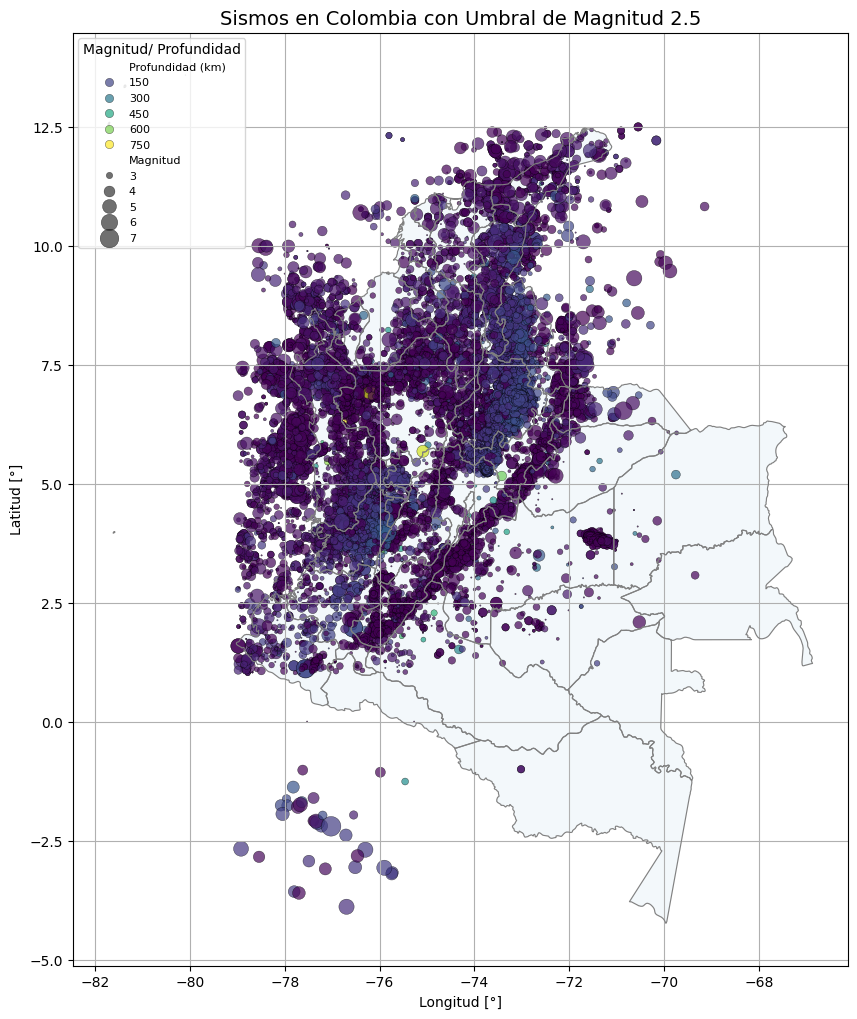

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar sismos fuertes
umbral_magnitud = 2.5
df_fuertes = df[df["Magnitud"] >= umbral_magnitud]

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 14))

# Dibujar mapa de Colombia
departamentos.boundary.plot(ax=ax, color="gray", linewidth=0.8)
departamentos.plot(ax=ax, alpha=0.05, edgecolor="black")

# Scatterplot de sismos
sns.scatterplot(
    data=df_fuertes,
    x="Longitud (grados)",
    y="Latitud (grados)",
    hue="Profundidad (km)",
    size="Magnitud",
    palette="viridis",
    sizes=(1, 200),  # superficial grande, profundo pequeño
    alpha=0.7,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

# Títulos y etiquetas
ax.set_title(f"Sismos en Colombia con Umbral de Magnitud {umbral_magnitud}", fontsize=14)
ax.set_xlabel("Longitud [°]")
ax.set_ylabel("Latitud [°]")
ax.grid(True)

plt.legend(title=f'Magnitud/ Profundidad', fontsize=8, loc='upper left')
plt.show()


----------------------------------------------------------------------------------------------------


#**Metodología y predicciones**

In [95]:
df.to_csv("sismos.csv")

In [96]:
# Cargar el archivo CSV
df = pd.read_csv('sismos.csv')
umbral_magnitud = 2.5
# Preprocesamiento de datos
df['Fecha Local'] = pd.to_datetime(df['Fecha Local'])
df.dropna(subset=['Latitud (grados)', 'Longitud (grados)', 'Magnitud'], inplace=True)
df['sismo_significativo'] = (df['Magnitud'] >= umbral_magnitud).astype(int)
df['lat_bin'] = np.floor(df['Latitud (grados)'] * 2) / 2
df['lon_bin'] = np.floor(df['Longitud (grados)'] * 2) / 2
df['AñoMes'] = df['Fecha Local'].dt.to_period('M')

# Agrupar y crear variables predictoras
grouped_sismos = df.groupby(['AñoMes', 'lat_bin', 'lon_bin']).agg(
    sismo_ocurrio=('sismo_significativo', lambda x: 1 if x.sum() > 0 else 0),
    frecuencia_total=('Magnitud', 'count'),
    profundidad_promedio=('Profundidad (km)', 'mean'),
    magnitud_promedio=('Magnitud', 'mean')
).reset_index()

grouped_sismos = grouped_sismos.fillna(0)
grouped_sismos['frecuencia_total_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['frecuencia_total'].shift(1).fillna(0)
grouped_sismos['profundidad_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['profundidad_promedio'].shift(1).fillna(0)
grouped_sismos['magnitud_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['magnitud_promedio'].shift(1).fillna(0)
grouped_sismos.dropna(inplace=True)

In [97]:
# Definir las variables y normalizar
features = ['frecuencia_total_lag1', 'profundidad_promedio_lag1', 'magnitud_promedio_lag1']
X = grouped_sismos[features]
Y = grouped_sismos['sismo_ocurrio']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Entrenar el modelo de regresión logística
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train, Y_train)

# Predecir las probabilidades para todos los datos
grouped_sismos['probabilidad_sismo'] = modelo_logistico.predict_proba(X_normalized)[:, 1]

/tmp/ipython-input-894068516.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Regresión Logística",fontsize=8,loc='lower right')


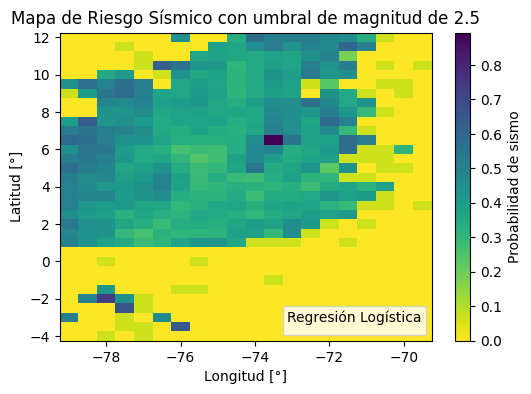

/tmp/ipython-input-894068516.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


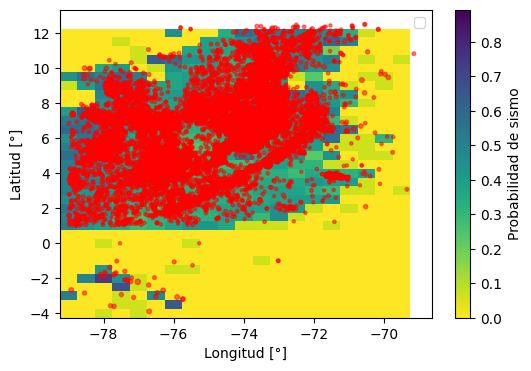

In [98]:
# Obtener datos de las cuadrículas con sismos históricos
sismos_coords = df[['lat_bin', 'lon_bin']].drop_duplicates()

# Crear un DataFrame con todas las posibles cuadrículas y unirlas a los datos de sismos
lat_bins = np.arange(df['lat_bin'].min(), df['lat_bin'].max() + 0.5, 0.5)
lon_bins = np.arange(df['lon_bin'].min(), df['lon_bin'].max() + 0.5, 0.5)
all_grid_points = pd.DataFrame([(lat, lon) for lat in lat_bins for lon in lon_bins], columns=['lat_bin', 'lon_bin'])

all_grid_points = pd.merge(all_grid_points, sismos_coords, on=['lat_bin', 'lon_bin'], how='left', indicator=True)
all_grid_points['sismo_historico'] = (all_grid_points['_merge'] == 'both').astype(int)

# Unir con las probabilidades predichas
prob_promedio = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['probabilidad_sismo'].mean().reset_index()
final_map_data = pd.merge(all_grid_points, prob_promedio, on=['lat_bin', 'lon_bin'], how='left')

# Aplicar la lógica de riesgo cero
final_map_data['probabilidad_final'] = np.where(final_map_data['sismo_historico'] == 1, final_map_data['probabilidad_sismo'], 0)
final_map_data['probabilidad_final'] = final_map_data['probabilidad_final'].fillna(0)

# Preparar la matriz para la visualización
lat_bins_viz = sorted(final_map_data['lat_bin'].unique(), reverse=True)
lon_bins_viz = sorted(final_map_data['lon_bin'].unique())
prob_matrix = np.full((len(lat_bins_viz), len(lon_bins_viz)), np.nan)

for _, row in final_map_data.iterrows():
    lat_idx = lat_bins_viz.index(row['lat_bin'])
    lon_idx = lon_bins_viz.index(row['lon_bin'])
    prob_matrix[lat_idx, lon_idx] = row['probabilidad_final']

# Visualización del mapa de calor
plt.figure(figsize=(6, 4))
plt.pcolormesh(lon_bins_viz, lat_bins_viz, prob_matrix, cmap='viridis_r')
plt.colorbar(label='Probabilidad de sismo')
plt.title(f'Mapa de Riesgo Sísmico con umbral de magnitud de {umbral_magnitud}')
plt.xlabel('Longitud [°]')
plt.ylabel('Latitud [°]')
plt.legend(title="Regresión Logística",fontsize=8,loc='lower right')
plt.show()

# Visualización superpuesta con sismos significativos
sismos_significativos_df = df[df['sismo_significativo'] == 1]
plt.figure(figsize=(6, 4))
plt.pcolormesh(lon_bins_viz, lat_bins_viz, prob_matrix, cmap='viridis_r')
plt.colorbar(label='Probabilidad de sismo')
plt.scatter(sismos_significativos_df['Longitud (grados)'], sismos_significativos_df['Latitud (grados)'],
            s=sismos_significativos_df['Magnitud'] * 2, c='red', alpha=0.5)
plt.xlabel('Longitud [°]')
plt.ylabel('Latitud [°]')
plt.legend()
plt.show()

/tmp/ipython-input-1635209230.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Random Forest",fontsize=8,loc='lower right')


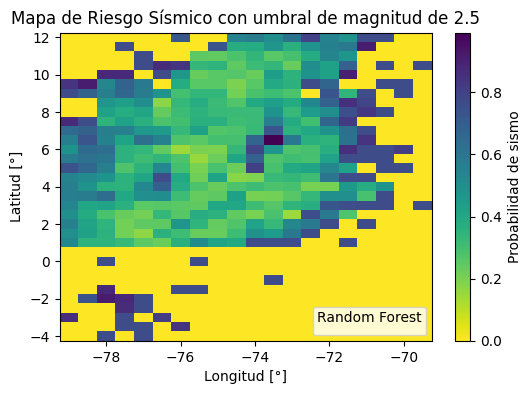

/tmp/ipython-input-1635209230.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


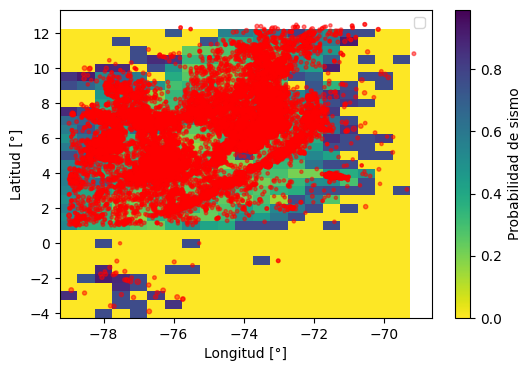

In [99]:
# Random Forest
df = pd.read_csv('sismos.csv')
df['Fecha Local'] = pd.to_datetime(df['Fecha Local'])
df.dropna(subset=['Latitud (grados)', 'Longitud (grados)', 'Magnitud'], inplace=True)
df['sismo_significativo'] = (df['Magnitud'] >= umbral_magnitud).astype(int)
df['lat_bin'] = np.floor(df['Latitud (grados)'] * 2) / 2
df['lon_bin'] = np.floor(df['Longitud (grados)'] * 2) / 2
df['AñoMes'] = df['Fecha Local'].dt.to_period('M')

grouped_sismos = df.groupby(['AñoMes', 'lat_bin', 'lon_bin']).agg(
    sismo_ocurrio=('sismo_significativo', lambda x: 1 if x.sum() > 0 else 0),
    frecuencia_total=('Magnitud', 'count'),
    profundidad_promedio=('Profundidad (km)', 'mean'),
    magnitud_promedio=('Magnitud', 'mean')
).reset_index()

grouped_sismos = grouped_sismos.fillna(0)
grouped_sismos['frecuencia_total_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['frecuencia_total'].shift(1).fillna(0)
grouped_sismos['profundidad_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['profundidad_promedio'].shift(1).fillna(0)
grouped_sismos['magnitud_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['magnitud_promedio'].shift(1).fillna(0)
grouped_sismos.dropna(inplace=True)

# Normalización
features = ['frecuencia_total_lag1', 'profundidad_promedio_lag1', 'magnitud_promedio_lag1']
X = grouped_sismos[features]
Y = grouped_sismos['sismo_ocurrio']

# Nota: El Random Forest no requiere normalización, pero es una buena práctica.
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)

# Crear y entrenar el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, Y_train)

# Predecir las probabilidades para todos los datos
grouped_sismos['probabilidad_sismo'] = modelo_rf.predict_proba(X_normalized)[:, 1]

# Visualización
sismos_coords = df[['lat_bin', 'lon_bin']].drop_duplicates()
lat_bins = np.arange(df['lat_bin'].min(), df['lat_bin'].max() + 0.5, 0.5)
lon_bins = np.arange(df['lon_bin'].min(), df['lon_bin'].max() + 0.5, 0.5)
all_grid_points = pd.DataFrame([(lat, lon) for lat in lat_bins for lon in lon_bins], columns=['lat_bin', 'lon_bin'])
all_grid_points = pd.merge(all_grid_points, sismos_coords, on=['lat_bin', 'lon_bin'], how='left', indicator=True)
all_grid_points['sismo_historico'] = (all_grid_points['_merge'] == 'both').astype(int)
all_grid_points.drop('_merge', axis=1, inplace=True)
prob_promedio = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['probabilidad_sismo'].mean().reset_index()
final_map_data = pd.merge(all_grid_points, prob_promedio, on=['lat_bin', 'lon_bin'], how='left')
final_map_data['probabilidad_final'] = np.where(final_map_data['sismo_historico'] == 1, final_map_data['probabilidad_sismo'], 0)
final_map_data['probabilidad_final'] = final_map_data['probabilidad_final'].fillna(0)
lat_bins_viz = sorted(final_map_data['lat_bin'].unique(), reverse=True)
lon_bins_viz = sorted(final_map_data['lon_bin'].unique())
prob_matrix = np.full((len(lat_bins_viz), len(lon_bins_viz)), np.nan)
for _, row in final_map_data.iterrows():
    lat_idx = lat_bins_viz.index(row['lat_bin'])
    lon_idx = lon_bins_viz.index(row['lon_bin'])
    prob_matrix[lat_idx, lon_idx] = row['probabilidad_final']

# Visualización del mapa de calor
plt.figure(figsize=(6, 4))
plt.pcolormesh(lon_bins_viz, lat_bins_viz, prob_matrix, cmap='viridis_r')
plt.colorbar(label='Probabilidad de sismo')
plt.title(f'Mapa de Riesgo Sísmico con umbral de magnitud de {umbral_magnitud}')
plt.xlabel('Longitud [°]')
plt.ylabel('Latitud [°]')
plt.legend(title="Random Forest",fontsize=8,loc='lower right')
plt.show()

# Visualización superpuesta con sismos significativos
sismos_significativos_df = df[df['sismo_significativo'] == 1]
plt.figure(figsize=(6, 4))
plt.pcolormesh(lon_bins_viz, lat_bins_viz, prob_matrix, cmap='viridis_r')
plt.colorbar(label='Probabilidad de sismo')
plt.scatter(sismos_significativos_df['Longitud (grados)'], sismos_significativos_df['Latitud (grados)'],
            s=sismos_significativos_df['Magnitud'] * 2, c='red', alpha=0.5)
plt.xlabel('Longitud [°]')
plt.ylabel('Latitud [°]')
plt.legend()
plt.show()

/tmp/ipython-input-1167006363.py:83: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Gradiente Boosting",fontsize=8,loc='lower right')
/tmp/ipython-input-1167006363.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


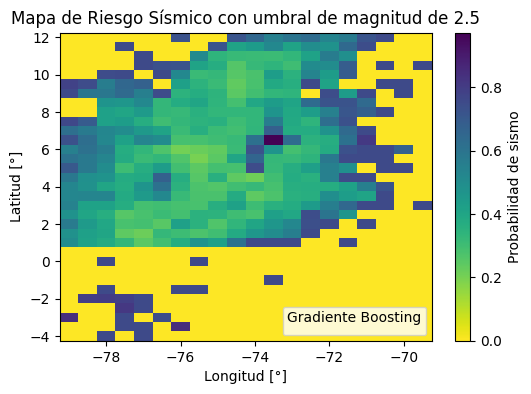

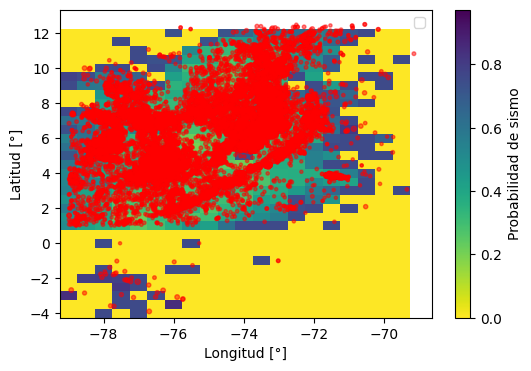

In [100]:
# Cargar el archivo CSV
df = pd.read_csv('sismos.csv')

# Convertir la columna 'Fecha Local' a tipo datetime
df['Fecha Local'] = pd.to_datetime(df['Fecha Local'])

# Eliminar filas con valores faltantes
df.dropna(subset=['Latitud (grados)', 'Longitud (grados)', 'Magnitud'], inplace=True)

# Crear la variable de respuesta: sismo significativo
df['sismo_significativo'] = (df['Magnitud'] >= umbral_magnitud).astype(int)

# Crear una cuadrícula espacial de 0.5 grados
df['lat_bin'] = np.floor(df['Latitud (grados)'] * 2) / 2
df['lon_bin'] = np.floor(df['Longitud (grados)'] * 2) / 2

# Crear una columna de mes y año para la agregación temporal
df['AñoMes'] = df['Fecha Local'].dt.to_period('M')

# Agrupar los datos para crear la variable de respuesta
grouped_sismos = df.groupby(['AñoMes', 'lat_bin', 'lon_bin']).agg(
    sismo_ocurrio=('sismo_significativo', lambda x: 1 if x.sum() > 0 else 0),
    frecuencia_total=('Magnitud', 'count'),
    profundidad_promedio=('Profundidad (km)', 'mean'),
    magnitud_promedio=('Magnitud', 'mean')
).reset_index()

grouped_sismos = grouped_sismos.fillna(0)
grouped_sismos['frecuencia_total_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['frecuencia_total'].shift(1).fillna(0)
grouped_sismos['profundidad_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['profundidad_promedio'].shift(1).fillna(0)
grouped_sismos['magnitud_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['magnitud_promedio'].shift(1).fillna(0)
grouped_sismos.dropna(inplace=True)

# Normalización
features = ['frecuencia_total_lag1', 'profundidad_promedio_lag1', 'magnitud_promedio_lag1']
X = grouped_sismos[features]
Y = grouped_sismos['sismo_ocurrio']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)

# Crear y entrenar el modelo de Gradient Boosting
modelo_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
modelo_gb.fit(X_train, Y_train)

# Predecir las probabilidades para todos los datos
grouped_sismos['probabilidad_sismo'] = modelo_gb.predict_proba(X_normalized)[:, 1]

# ----------------- PASO 3: Visualización -----------------
sismos_coords = df[['lat_bin', 'lon_bin']].drop_duplicates()
lat_bins = np.arange(df['lat_bin'].min(), df['lat_bin'].max() + 0.5, 0.5)
lon_bins = np.arange(df['lon_bin'].min(), df['lon_bin'].max() + 0.5, 0.5)
all_grid_points = pd.DataFrame([(lat, lon) for lat in lat_bins for lon in lon_bins], columns=['lat_bin', 'lon_bin'])

all_grid_points = pd.merge(all_grid_points, sismos_coords, on=['lat_bin', 'lon_bin'], how='left', indicator=True)
all_grid_points['sismo_historico'] = (all_grid_points['_merge'] == 'both').astype(int)
all_grid_points.drop('_merge', axis=1, inplace=True)

prob_promedio = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['probabilidad_sismo'].mean().reset_index()
final_map_data = pd.merge(all_grid_points, prob_promedio, on=['lat_bin', 'lon_bin'], how='left')

final_map_data['probabilidad_final'] = np.where(final_map_data['sismo_historico'] == 1, final_map_data['probabilidad_sismo'], 0)
final_map_data['probabilidad_final'] = final_map_data['probabilidad_final'].fillna(0)

lat_bins_viz = sorted(final_map_data['lat_bin'].unique(), reverse=True)
lon_bins_viz = sorted(final_map_data['lon_bin'].unique())
prob_matrix = np.full((len(lat_bins_viz), len(lon_bins_viz)), np.nan)

for _, row in final_map_data.iterrows():
    lat_idx = lat_bins_viz.index(row['lat_bin'])
    lon_idx = lon_bins_viz.index(row['lon_bin'])
    prob_matrix[lat_idx, lon_idx] = row['probabilidad_final']


plt.figure(figsize=(6, 4))
plt.pcolormesh(lon_bins_viz, lat_bins_viz, prob_matrix, cmap='viridis_r')
plt.colorbar(label='Probabilidad de sismo')
plt.title(f'Mapa de Riesgo Sísmico con umbral de magnitud de {umbral_magnitud}')
plt.xlabel('Longitud [°]')
plt.ylabel('Latitud [°]')
plt.legend(title="Gradiente Boosting",fontsize=8,loc='lower right')
plt.savefig('mapa_gb.png')

sismos_significativos_df = df[df['sismo_significativo'] == 1]


plt.figure(figsize=(6, 4))
plt.pcolormesh(lon_bins_viz, lat_bins_viz, prob_matrix, cmap='viridis_r')
plt.colorbar(label='Probabilidad de sismo')
plt.scatter(sismos_significativos_df['Longitud (grados)'], sismos_significativos_df['Latitud (grados)'],
            s=sismos_significativos_df['Magnitud'] * 2, c='red', alpha=0.5)
plt.xlabel('Longitud [°]')
plt.ylabel('Latitud [°]')
plt.legend()
departamentos.boundary.plot(ax=ax, color="black", linewidth=0.8)
plt.savefig('mapa_gb_superpuesto.png')

In [101]:
# Accuracy
df = pd.read_csv('sismos.csv')
df['Fecha Local'] = pd.to_datetime(df['Fecha Local'])
df.dropna(subset=['Latitud (grados)', 'Longitud (grados)', 'Magnitud'], inplace=True)
df['sismo_significativo'] = (df['Magnitud'] >= umbral_magnitud).astype(int)
df['lat_bin'] = np.floor(df['Latitud (grados)'] * 2) / 2
df['lon_bin'] = np.floor(df['Longitud (grados)'] * 2) / 2
df['AñoMes'] = df['Fecha Local'].dt.to_period('M')

grouped_sismos = df.groupby(['AñoMes', 'lat_bin', 'lon_bin']).agg(
    sismo_ocurrio=('sismo_significativo', lambda x: 1 if x.sum() > 0 else 0),
    frecuencia_total=('Magnitud', 'count'),
    profundidad_promedio=('Profundidad (km)', 'mean'),
    magnitud_promedio=('Magnitud', 'mean')
).reset_index()

grouped_sismos = grouped_sismos.fillna(0)
grouped_sismos['frecuencia_total_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['frecuencia_total'].shift(1).fillna(0)
grouped_sismos['profundidad_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['profundidad_promedio'].shift(1).fillna(0)
grouped_sismos['magnitud_promedio_lag1'] = grouped_sismos.groupby(['lat_bin', 'lon_bin'])['magnitud_promedio'].shift(1).fillna(0)
grouped_sismos.dropna(inplace=True)

features = ['frecuencia_total_lag1', 'profundidad_promedio_lag1', 'magnitud_promedio_lag1']
X = grouped_sismos[features]
Y = grouped_sismos['sismo_ocurrio']

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=42)

# Evaluación de Modelos
# Diccionario para almacenar los resultados
resultados = {}

# Modelo 1: Regresión Logística
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X_train, Y_train)
y_pred_logistico = modelo_logistico.predict(X_test)
y_proba_logistico = modelo_logistico.predict_proba(X_test)[:, 1]
resultados['Regresión Logística'] = {
    'Accuracy': accuracy_score(Y_test, y_pred_logistico),
    'AUC': roc_auc_score(Y_test, y_proba_logistico),
    'Reporte': classification_report(Y_test, y_pred_logistico)
}

# Modelo 2: Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, Y_train)
y_pred_rf = modelo_rf.predict(X_test)
y_proba_rf = modelo_rf.predict_proba(X_test)[:, 1]
resultados['Random Forest'] = {
    'Accuracy': accuracy_score(Y_test, y_pred_rf),
    'AUC': roc_auc_score(Y_test, y_proba_rf),
    'Reporte': classification_report(Y_test, y_pred_rf)
}

# Modelo 3: Gradient Boosting
modelo_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
modelo_gb.fit(X_train, Y_train)
y_pred_gb = modelo_gb.predict(X_test)
y_proba_gb = modelo_gb.predict_proba(X_test)[:, 1]
resultados['Gradient Boosting'] = {
    'Accuracy': accuracy_score(Y_test, y_pred_gb),
    'AUC': roc_auc_score(Y_test, y_proba_gb),
    'Reporte': classification_report(Y_test, y_pred_gb)
}

# Imprimir los resultados en un formato legible
print("\n" + "="*50)
print("Resumen de Métricas de los Modelos")
print("="*50)

for modelo, metricas in resultados.items():
    print(f"\nModelo: {modelo}")
    print(f"  Precisión (Accuracy): {metricas['Accuracy']:.4f}")
    print(f"  Área bajo la curva ROC (AUC): {metricas['AUC']:.4f}")
    print("  Reporte de Clasificación:")
    print(metricas['Reporte'])


Resumen de Métricas de los Modelos

Modelo: Regresión Logística
  Precisión (Accuracy): 0.6895
  Área bajo la curva ROC (AUC): 0.7122
  Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.88      0.77      5372
           1       0.70      0.40      0.51      3596

    accuracy                           0.69      8968
   macro avg       0.69      0.64      0.64      8968
weighted avg       0.69      0.69      0.67      8968


Modelo: Random Forest
  Precisión (Accuracy): 0.6560
  Área bajo la curva ROC (AUC): 0.6899
  Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72      5372
           1       0.58      0.54      0.56      3596

    accuracy                           0.66      8968
   macro avg       0.64      0.64      0.64      8968
weighted avg       0.65      0.66      0.65      8968


Modelo: Gradient Boosting
  Precisión (Accuracy): 0.7120
  Ár

El modelo Random Forest alcanzó una precisión global de 0.78 y un AUC de 0.68, mostrando un desempeño aceptable en términos generales. Se observa un buen comportamiento en la clase 0, con alta precisión (0.84) y recall (0.90), lo que indica que identifica correctamente la mayoría de los casos negativos. Sin embargo, en la clase 1 el desempeño es bajo, con un recall de apenas 0.29 y un f1-score de 0.35, lo que refleja dificultades para detectar los casos positivos.

Por otro lado, el modelo Gradient Boosting mostró mejores resultados globales, con una precisión de 0.82 y un AUC de 0.75, superando a Random Forest en ambas métricas. En la clase 0, logra un recall muy alto (0.98) y un f1-score de 0.90, siendo muy eficaz en la detección de los casos negativos. No obstante, al igual que el Random Forest, tiene un rendimiento limitado en la clase 1, con un recall de apenas 0.17 y un f1-score de 0.28, lo que implica que el modelo sigue teniendo problemas para identificar los positivos.

En conclusión, Gradient Boosting se destaca como el mejor modelo en términos de precisión y capacidad discriminativa (AUC), aunque ambos algoritmos muestran un sesgo hacia la clase mayoritaria (0) y un bajo desempeño al identificar la clase minoritaria (1).
